<b>AML2019</b>

<h3>Challenge 1</h3>
<h1>House Pricing Prediction</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>
<i>22<sup>th</sup> March 2019</i>

The first AML challenge for this year is adapted from the well-known '<i>Zillow's Home Value Prediction</i>' competition on Kaggle.
In particular, given a dataset containing descriptions of homes on the US property market, your task is to make predictions on the selling price of as-yet unlisted properties. 
Developing a model which accurately fits the available training data while also generalising to unseen data-points is a multi-faceted challenge that involves a mixture of data exploration, pre-processing, model selection, and performance evaluation.

# Overview
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

Beyond simply producing a well-performing model for making predictions, in this challenge we would like you to start developing your skills as a machine learning scientist.
In this regard, your notebook should be structured in such a way as to explore the five following tasks that are expected to be carried out whenever undertaking such a project.
The description below each aspect should serve as a guide for your work, but you are strongly encouraged to also explore alternative options and directions. 
Thinking outside the box will always be rewarded in these challenges.

In [51]:
%matplotlib inline
import os
import sys
import re
import random
import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from time import time

os.environ["OPENBLAS_NUM_THREADS"] = "1"   # Required by implicit
base = './'

import warnings
warnings.filterwarnings("ignore")

<div class="">
    <h3>1. Data Exploration</h3>
</div>

The first broad component of your notebook should enable you to familiarise yourselves with the given data, an outline of which is given at the end of this challenge specification.
Among others, this section should investigate:

- Data cleaning, e.g. treatment of categorial variables;
- Data visualisation;
- Computing descriptive statistics, e.g. correlation.
- etc.

#### Data cleaning and treatment of categorical variables

In [44]:
# Read the .csv file
trainDF = pd.read_csv(base + 'challenge_data/train.csv', 
                           sep=',', 
                           header='infer')

In [5]:
trainDF.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

*To have a better visualization of the dataset, we retrieve the name of all columns with their number of unique values.*

In [18]:
column_names = list(trainDF.columns.values)
print('The total number of features is : ', len(column_names))

for c_name in column_names [:5] :
    print('nb of uniques values in column '+ c_name + ' : ' + str(trainDF[c_name].nunique()))

The total number of features is :  81
nb of uniques values in column Id : 1200
nb of uniques values in column MSSubClass : 15
nb of uniques values in column MSZoning : 5
nb of uniques values in column LotFrontage : 106
nb of uniques values in column LotArea : 913


*To identify which columns have NaN values :*

In [22]:
trainDF.isna().any()[:5]

Id             False
MSSubClass     False
MSZoning       False
LotFrontage     True
LotArea        False
dtype: bool

*Nan values are quite problematic in the estimation model. To deal with it, we first decide to identify within all the columns, which are numeric features and which are categorical ones. We assume that all the columns where the correlation cannot be computed are categorical data.
In order to do so, let's compute the correlation coefficients of all columns with the SalePrice to understand their contribution to hte final price. The .corr() pandas function computes pairwise correlation of columns, excluding NA/null values.*

In [47]:
corrDF = trainDF.corr()
trainDF[trainDF.columns[0:]].corr()['SalePrice'][:-1]

Id              -0.019222
MSSubClass      -0.075817
LotFrontage      0.378387
LotArea          0.266811
OverallQual      0.789142
OverallCond     -0.082580
YearBuilt        0.523194
YearRemodAdd     0.509916
MasVnrArea       0.481406
BsmtFinSF1       0.407568
BsmtFinSF2      -0.002920
BsmtUnfSF        0.206050
TotalBsmtSF      0.641917
1stFlrSF         0.618556
2ndFlrSF         0.348623
LowQualFinSF    -0.027071
GrLivArea        0.740379
BsmtFullBath     0.221209
BsmtHalfBath    -0.017281
FullBath         0.571867
HalfBath         0.299779
BedroomAbvGr     0.183829
KitchenAbvGr    -0.133544
TotRmsAbvGrd     0.559435
Fireplaces       0.458528
GarageYrBlt      0.489794
GarageCars       0.640961
GarageArea       0.623329
WoodDeckSF       0.315379
OpenPorchSF      0.315548
EnclosedPorch   -0.119790
3SsnPorch        0.020826
ScreenPorch      0.119891
PoolArea         0.103644
MiscVal         -0.036877
MoSold           0.047015
YrSold          -0.039841
Name: SalePrice, dtype: float64

*It remains only 38 columns over the 81 : only those are numerical. We create a dataframe to keep those columns and their correlation coefficients :*

In [48]:
exploreDF = pd.DataFrame(columns=['name_col', 'corr ac SP', 'nunique', 'NaN values?'])  #DELETE THIS LINE

column_names_in_corr = list(corrDF.columns.values)
for c_name in column_names_in_corr :
    row = {'name_col':c_name, 'corr with SalePrice':corrDF.loc['SalePrice', c_name], 'nunique':trainDF[c_name].nunique(), 'NaN values?': trainDF[c_name].isna().any()}
    exploreDF = exploreDF.append(row, ignore_index=True)

pd.set_option('display.max_rows', 38)
display(exploreDF)

name_col  corr ac SP nunique NaN values?  corr with SalePrice
0              Id         NaN    1200       False            -0.019222
1      MSSubClass         NaN      15       False            -0.075817
2     LotFrontage         NaN     106        True             0.378387
3         LotArea         NaN     913       False             0.266811
4     OverallQual         NaN      10       False             0.789142
5     OverallCond         NaN       9       False            -0.082580
6       YearBuilt         NaN     108       False             0.523194
7    YearRemodAdd         NaN      61       False             0.509916
8      MasVnrArea         NaN     283        True             0.481406
9      BsmtFinSF1         NaN     567       False             0.407568
10     BsmtFinSF2         NaN     116       False            -0.002920
11      BsmtUnfSF         NaN     691       False             0.206050
12    TotalBsmtSF         NaN     642       False             0.641917
13       1stFlrSF         NaN     676       False             0.618556
14       2ndFlrSF         NaN     361       False             0.348623
15   LowQualFinSF         NaN      22       False            -0.027071
16      GrLivArea         NaN     761       False             0.740379
17   BsmtFullBath         NaN       4       False             0.221209
18   BsmtHalfBath         NaN       3       False            -0.017281
19       FullBath         NaN       4       False             0.571867
20       HalfBath         NaN       3       False             0.299779
21   BedroomAbvGr         NaN       8       False             0.183829
22   KitchenAbvGr         NaN       4       False            -0.133544
23   TotRmsAbvGrd         NaN      12       False             0.559435
24     Fireplaces         NaN       4       False             0.458528
25    GarageYrBlt         NaN      95        True             0.489794
26     GarageCars         NaN       5       False             0.640961
27     GarageArea         NaN     402       False             0.623329
28     WoodDeckSF         NaN     247       False             0.315379
29    OpenPorchSF         NaN     187       False             0.315548
30  EnclosedPorch         NaN     104       False            -0.119790
31      3SsnPorch         NaN      18       False             0.020826
32    ScreenPorch         NaN      65       False             0.119891
33       PoolArea         NaN       5       False             0.103644
34        MiscVal         NaN      18       False            -0.036877
35         MoSold         NaN      12       False             0.047015
36         YrSold         NaN       5       False            -0.039841
37      SalePrice         NaN     596       False             1.000000

*Among numerical features only 3 contain NaN values. 
To make the use of all the columns easier, we decide to now replace all the NaN values by -1.*

*We identify the categorical columns and numerize them. Two methods can here be applied :* 

*  replacing each category by a number
*  duplicating the column into n columns (n being the number of categories in the column) filled only by 0 and 1

*We choose the first option because even if there is no order within categories in a same column, we don't want to have too many columns to deal with (several columns have more than 100 differents categories).*
*With the cat.codes function, NaN are directly converted into -1.*

In [49]:
column_names_notin_corr = []
for x in column_names:
    if not (x in column_names_in_corr) :
        column_names_notin_corr.append(x)
print('Categorical features : ',column_names_notin_corr)
print('Number of categorical features : ',len(column_names_notin_corr))

for x in column_names_notin_corr:
    trainDF[x] = trainDF[x].astype('category')
    trainDF[x+'_cat'] = trainDF[x].cat.codes

Categorical features :  ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Number of categorical features :  43


In [92]:
print('DataFrame containing all numerical features : ')
inter_trainDF = trainDF.drop(column_names_notin_corr, axis=1)
inter_trainDF.head()

DataFrame containing all numerical features : 


Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1        ...          GarageType_cat  \
0          2003       196.0         706        ...                       1   
1          1976         0.0         978        ...                       1   
2          2002       162.0         486        ...                       1   
3          1970         0.0         216        ...                       5   
4          2000       350.0         655        ...                       1   

   GarageFinish_cat  GarageQual_cat  GarageCond_cat  PavedDrive_cat  \
0                 1               4               4               2   
1                 1               4               4               2   
2                 1               4               4               2   
3                 2               4               4               2   
4                 1               4               4               2   

   PoolQC_cat  Fence_cat  MiscFeature_cat  SaleType_cat  SaleCondition_cat  
0          -1         -1               -1             8                  4  
1          -1         -1               -1             8                  4  
2          -1         -1               -1             8                  4  
3          -1         -1               -1             8                  0  
4          -1         -1               -1             8                  4  

[5 rows x 81 columns]

In [93]:
#Filling the NaN values of the numerical features

inter_trainDF['LotFrontage'] = inter_trainDF['LotFrontage'].astype('category').cat.add_categories([-1]).fillna(-1)
inter_trainDF['MasVnrArea'] = inter_trainDF['MasVnrArea'].astype('category').cat.add_categories([-1]).fillna(-1)
inter_trainDF['GarageYrBlt'] = inter_trainDF['GarageYrBlt'].astype('category').cat.add_categories([-1]).fillna(-1)

And now is there NaN?

In [52]:
inter_trainDF.isnull().any().any()

False

#### Features selection using correlations

*The aim of computing the correlation coefficients is to find the influence of each features on the final sale price. We though that making a selection within features could make our predictions more faster while still accurate.
In that aim, we have decided to define our threshold at 0.3 (in absolute value) in order to select the more significant features.*

In [103]:
corrDF2 = inter_trainDF.corr()
corrDF2.loc['SalePrice'].sort_values()

#Identification of the less significant features
column_names_in_corr = list(corrDF2.columns.values)
column_names_in_corr_NOK2 =[]
for c_name in column_names_in_corr :
    if not((corrDF2.loc['SalePrice', c_name] > 0.3) or (corrDF2.loc['SalePrice', c_name] < -0.3)):
        column_names_in_corr_NOK2.append(c_name)

column_names_in_corr_NOK2.remove("Id")

print('Number of most significant features : ', 81 - len(column_names_in_corr_NOK2))

#The dataframe containing the IDs and the most significant features
new_trainDF = inter_trainDF.drop(column_names_in_corr_NOK2, axis=1)
new_trainDF.head()

Number of most significant features :  26


Id LotFrontage  OverallQual  YearBuilt  YearRemodAdd MasVnrArea  \
0   1        65.0            7       2003          2003      196.0   
1   2        80.0            6       1976          1976        0.0   
2   3        68.0            7       2001          2002      162.0   
3   4        60.0            7       1915          1970        0.0   
4   5        84.0            8       2000          2000      350.0   

   BsmtFinSF1  TotalBsmtSF  1stFlrSF  2ndFlrSF       ...         GarageArea  \
0         706          856       856       854       ...                548   
1         978         1262      1262         0       ...                460   
2         486          920       920       866       ...                608   
3         216          756       961       756       ...                642   
4         655         1145      1145      1053       ...                836   

   WoodDeckSF  OpenPorchSF  SalePrice ExterQual_cat  Foundation_cat  \
0           0           61     208500             2               2   
1         298            0     181500             3               1   
2           0           42     223500             2               2   
3           0           35     140000             3               0   
4         192           84     250000             2               2   

   BsmtQual_cat  HeatingQC_cat  KitchenQual_cat  FireplaceQu_cat  
0             2              0                2               -1  
1             2              0                3                4  
2             2              0                2                4  
3             3              2                2                2  
4             2              0                2                4  

[5 rows x 26 columns]

#### Data visualisation

*The first thing we've done was to try to visualise the variables that are the most correlated with SalePrice.*

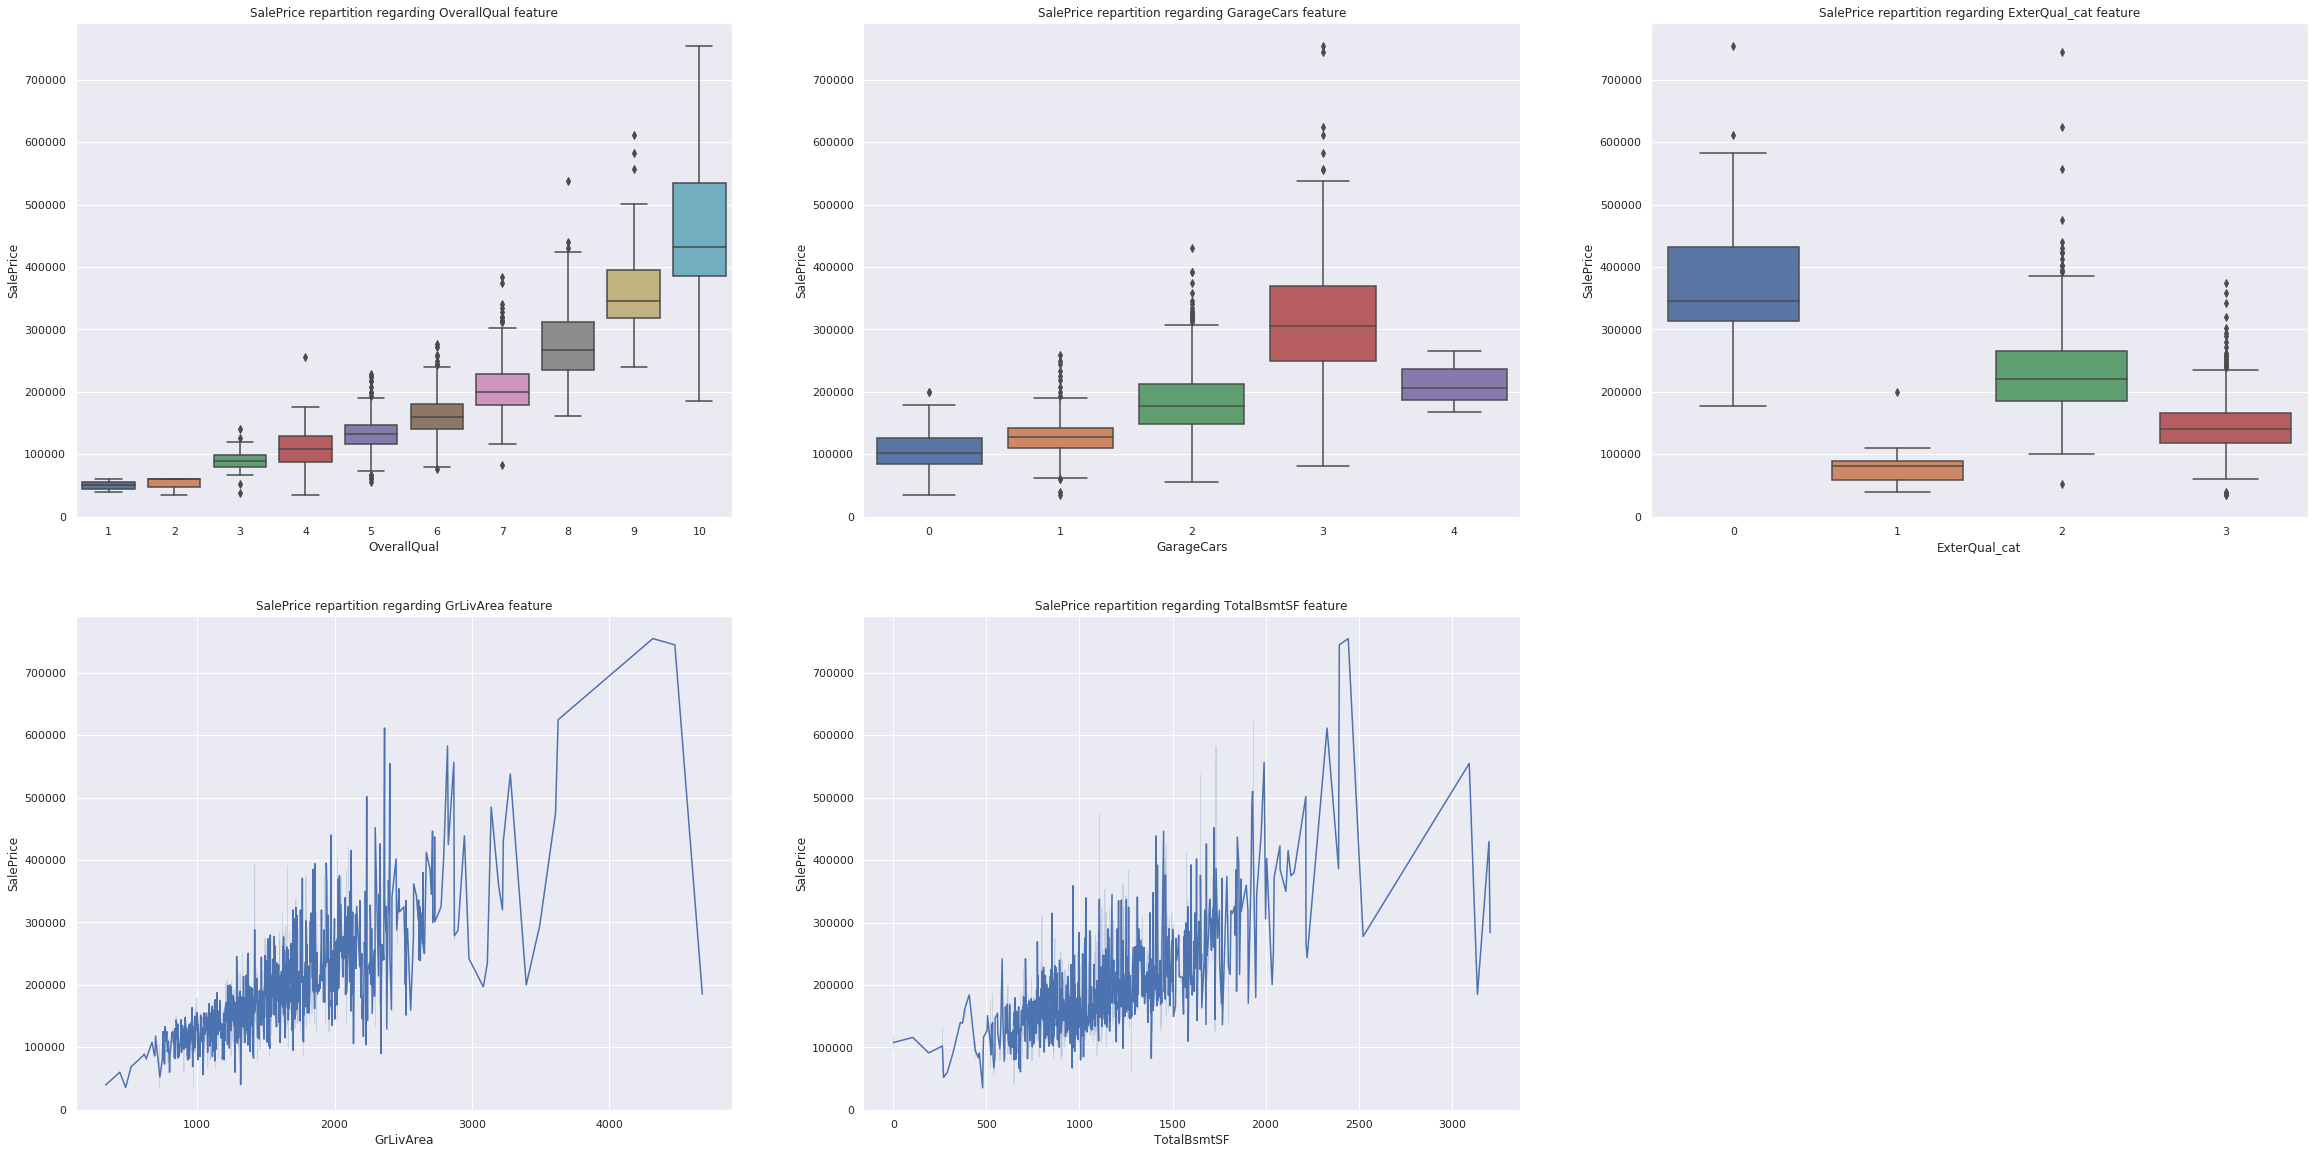

In [126]:
import seaborn as sns
figure = plt.figure(figsize=(40,20))

sns.set()

plt.subplot(2,3,1)
plt.title('SalePrice repartition regarding OverallQual feature')
sns.boxplot(x='OverallQual', y='SalePrice', data=new_trainDF)

plt.subplot(2,3,2)
plt.title('SalePrice repartition regarding GarageCars feature')
sns.boxplot(x='GarageCars', y='SalePrice', data=new_trainDF)

plt.subplot(2,3,3)
plt.title('SalePrice repartition regarding ExterQual_cat feature')
sns.boxplot(x='ExterQual_cat', y='SalePrice', data=new_trainDF)

plt.subplot(2,3,4)
plt.title('SalePrice repartition regarding GrLivArea feature')
sns.lineplot(x='GrLivArea', y='SalePrice', data=new_trainDF)

plt.subplot(2,3,5)
plt.title('SalePrice repartition regarding TotalBsmtSF feature')
sns.lineplot(x='TotalBsmtSF', y='SalePrice', data=new_trainDF)

#### Removing outliers

*Outliers must be removed of the dataset in order to avoid statiscal impacts and uncorrect predictions. To know if there is some outliers in our dataset, we visualize the sale price distribution :*

count      1200.000000
mean     181414.628333
std       81070.908544
min       34900.000000
25%      129900.000000
50%      163700.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


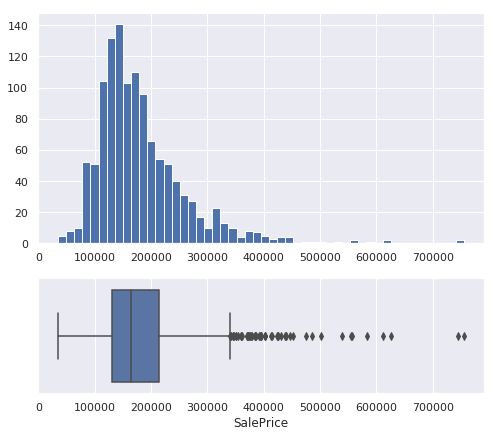

In [54]:
import seaborn as sns
from matplotlib import gridspec
figure = plt.figure(figsize=(8,7))

gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

plt.subplot(gs[0])
trainDF['SalePrice'].hist(bins=50)
sns.set()
plt.subplot(gs[1])

sns.boxplot(x='SalePrice', data=inter_trainDF)
print(inter_trainDF['SalePrice'].describe())

count      1152.000000
mean     170726.044271
std       60144.723009
min       34900.000000
25%      129000.000000
50%      159975.000000
75%      205000.000000
max      348000.000000
Name: SalePrice, dtype: float64


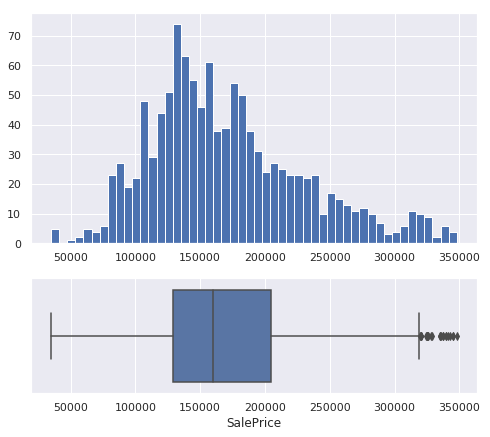

In [55]:
#Removing the outliers of the dataframe containing all the features
inter_without_outliers_trainDF = inter_trainDF[inter_trainDF['SalePrice'] < 350000]

#Removing the outliers of the dataframe containing the selected features
new_without_outliers_trainDF = new_trainDF[new_trainDF['SalePrice'] < 350000]

figure = plt.figure(figsize=(8,7))


gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
plt.subplot(gs[0])
inter_without_outliers_trainDF['SalePrice'].hist(bins=50)
plt.subplot(gs[1])
sns.boxplot(x='SalePrice', data=inter_without_outliers_trainDF)

print(inter_without_outliers_trainDF['SalePrice'].describe())

*We have only kept the houses for which the price is inferior at 350 000$. We can see than we have removed less than 4% of the houses.*

#### Normalization

*As explained https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler, standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.
For instance, many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the l1 and l2 regularizers of linear models) assume that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.*

In [56]:
from sklearn import preprocessing

X80 = inter_without_outliers_trainDF.drop('SalePrice', axis=1) 
y80 = inter_without_outliers_trainDF['SalePrice'] 

#Normalisation of the features only
X80norm, norms80 = preprocessing.normalize(X80, norm='l2', return_norm=True, axis=0)

X25 = new_without_outliers_trainDF.drop('SalePrice', axis=1) 
y25 = new_without_outliers_trainDF['SalePrice'] 

#Normalisation of the features only
X25norm, norms25 = preprocessing.normalize(X25, norm='l2', return_norm=True, axis=0)

#### Conclusion

*We have, in this first step, handle with the  missing information in the dataset by removing all NaN values and making all categorical features numerical ones. We have also selected a number of features with the highest correlation with SalePrice. The next step was to normalize and remove outliers.*
*We will continue to work on two sets of data :*
* **X80norm & y80** : the original DF splitted in 2, but with integers instead of all non numerical categorical columns and with outliers removed, 80 columns
* **X25norm & y25** : a reduced version of the other one, 25 columns of integers, with outliers removed and all with a correlation with `SalePrice` higher than 0.3 in absolut value

---
---

<div class="">
    <h3>3. Model Selection</h3>
</div>

Perhaps the most important segment of this challenge involves the selection of a model that can successfully handle the given data and yield sensible predictions.
Instead of focusing exclusively on your final chosen model, it is also important to share your thought process in this notebook by additionally describing alternative candidate models.
There is a wealth of models to choose from, such as <i>decision trees</i>, <i>random forests</i>, <i>(Bayesian) neural networks</i>, <i>Gaussian processes</i>, <i>LASSO regression</i>, and so on.
There are several factors which may influence your decision:

- What is the model's complexity?
- Is the model interpretable?
- Is the model capable of handling different data-types?
- Does the model return uncertainty estimates along with predictions?

An in-depth evaluation of competing models in view of this and other criteria will elevate the quality of your submission and earn you a higher grade.


<div class="">
    <h3>4. Parameter Optimisation</h3>
</div>

Irrespective of your choice, it is highly likely that your model will have one or more parameters that require tuning.
There are several techniques for carrying out such a procedure, including cross-validation, Bayesian optimisation, and several others.
As before, an analysis into which parameter tuning technique best suits your model is expected before proceeding with the optimisation of your model.

<div class="">
    <h3>5. Model Evaluation</h3>
</div>

Some form of pre-evaluation will inevitably be required in the preceding sections in order to both select an appropriate model and configure its parameters appropriately.
In this final section, you may evaluate other aspects of the model such as:

- Assessing the running time of your model;
- Determining whether some aspects can be parallelised;
- Training the model with smaller subsets of the data.
- etc.

<div class="alert alert-danger">
    <b>N.B.</b> Please note that the items listed under each heading are neither exhaustive, nor are you expected to explore every given suggestion.
    Nonetheless, these should serve as a guideline for your work in both this and upcoming challenges.
    As always, you should use your intuition and understanding in order to decide which analysis best suits the assigned task.
</div>

---
---

***We have decided to put together part 3, 4 and 5 to select models, optimize their hyperparameters and evaluate them one by one.
Our criteria to evaluate models will be the following :***
* ***the coefficient of determination r2 between our predictions and the true values expected. Indeed, each time we will try a model, we will plot the predictions VS the true values as a set of points. Ideally, we would like to obtain the line $f(x)=x$    - which we'll also plot as comparison with our points.***
* ***the root mean squared error between the logarithm of the predicted value and the logarithm of the observed sales price (we will call him rmsle on this notebook)***
* ***eventually the time of computation, to avoid too expensive model***

***Now let's get into it!***



To be a bit guided in choosing a good model, we will first use the following scikitlearn flowchart : 

![alt text](./ml_map.png "Sklearn flowchart")

*https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html*

We have fortunately more than 50 samples (1200 to be precise). We want to predict the quantity `SalePrice`, so we will do **Regression**.
Let's assume that few features should be important... the flowchart suggests us to try with Lasso regression, so that's what we'll begin with.

**LASSO REGRESSION**
---

As explained in https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html, **Lasso** mathematically consists of a linear model trained with ${ l }_{ 1 }$ prior as regularizer. The objective function to minimize is:
$$
\underset { w }{ min } \frac { 1 }{ 2{ n }_{ samples } } { \left\| Xw-y \right\|  }_{ 2 }^{ 2 }+\alpha { \left\| w \right\|  }_{ 1 }
$$
Let's test it with all our 80 columns at first. To implement our first version of the algorythm, we inspired ourselves from the example given here : https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_and_elasticnet.html#sphx-glr-auto-examples-linear-model-plot-lasso-and-elasticnet-py.

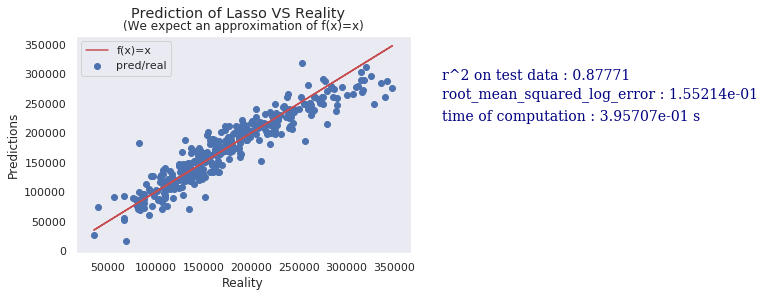

r^2 on test data : 0.87771
root_mean_squared_log_error : 1.55214e-01
time of computation : 3.95707e-01 s


In [146]:
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from math import log10, sqrt
import time 

plt.ylabel('Predictions')
font = {'family': 'serif', 'color':  'navy', 'weight': 'normal', 'size': 14}

X_train, X_test, y_train, y_test = train_test_split(X80norm, y80, test_size=0.33, random_state=42)

alpha = 0.1
t1 = time.time()

lasso = Lasso(alpha=alpha,  max_iter=3000)

y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)

a=(time.time()-t1)

r2_score_lasso = r2_score(y_test, y_pred_lasso)
rmsle_lasso = sqrt(mean_squared_log_error(y_test, y_pred_lasso))

plt.text(400000, 290000,"r^2 on test data : %.5f" % r2_score_lasso, fontdict=font)
plt.text(400000, 260000,"root_mean_squared_log_error : %.5e" % rmsle_lasso, fontdict=font)
plt.text(400000, 220000,'time of computation : %.5e s' % (a), fontdict=font)

plt.plot(y_test, y_test, color='r', label='f(x)=x')
plt.scatter(y_test, y_pred_lasso, label='pred/real')
plt.grid()

plt.xlabel('Reality')
plt.ylabel('Predictions')

plt.suptitle('Prediction of Lasso VS Reality')
plt.title('(We expect an approximation of f(x)=x)')
plt.legend()

plt.show()

print("r^2 on test data : %.5f" % r2_score_lasso)
print("root_mean_squared_log_error : %.5e" % rmsle_lasso)
print('time of computation : %.5e s' % (a))

With a little change on $\alpha$ compared to the example given by the documentation of the library scikit-learn, we already obtain quite good results : 
* r^2 = 0.87771
* rmsle =  1.55214e-01

Moreover, the time of computation is quite low (0.4s).

Let's try with different values of $\alpha$, to see if we can improve our criteria of evaluation. In this context, we will use LassoCV(), defined in teh documentation as a **cross-validation estimator**. It's indeed an estimator (here lasso) that has built-in cross-validation capabilities to automatically select the best hyper-parameters (here $\alpha$). It tend to be roughly equivalent to `GridSearchCV(Lasso(), …)`.

Computing regularization path using the coordinate descent lasso...
Our best alpha is :  0.0


(-4.500000000000001e-09, 9.45e-08, 112467345.73710689, 2840922292.94072)

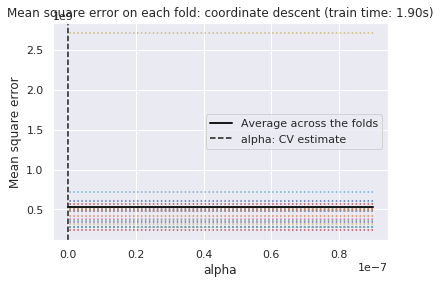

In [178]:
from sklearn.linear_model import LassoCV
# LassoCV: coordinate descent
alphas=[k for k in np.arange(0,1e-07,1e-08)]

# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
model = LassoCV(alphas=alphas, cv=20).fit(X80norm, y80)
t_lasso_cv = time.time() - t1

# Display results
print("Our best alpha is : ", model.alpha_)

plt.figure()
plt.plot(model.alphas_, model.mse_path_, ':')
plt.plot(model.alphas_, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(model.alpha_, linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('alpha')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')

Let's visualize the result with such an optimized alpha!

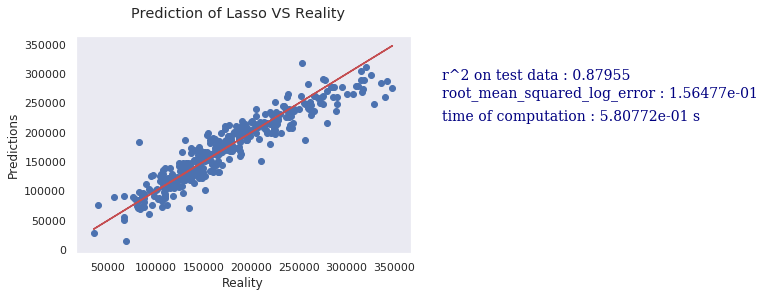

r^2 on test data : 0.87955
root_mean_squared_log_error : 1.56477e-01
time of computation : 5.80772e-01 s


In [179]:
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from math import log10, sqrt
import time 

plt.ylabel('Predictions')
font = {'family': 'serif', 'color':  'navy', 'weight': 'normal', 'size': 14}

X_train, X_test, y_train, y_test = train_test_split(X80norm, y80, test_size=0.33, random_state=42)

alpha = 0
t1 = time.time()

lasso = Lasso(alpha=alpha,  max_iter=3000)

y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
a=(time.time()-t1)

r2_score_lasso = r2_score(y_test, y_pred_lasso)
rmsle_lasso = sqrt(mean_squared_log_error(y_test, y_pred_lasso))

plt.text(400000, 290000,"r^2 on test data : %.5f" % r2_score_lasso, fontdict=font)
plt.text(400000, 260000,"root_mean_squared_log_error : %.5e" % rmsle_lasso, fontdict=font)
plt.text(400000, 220000,'time of computation : %.5e s' % (a), fontdict=font)

plt.plot(y_test, y_test, color='r')
plt.scatter(y_test, y_pred_lasso)
plt.grid()

plt.xlabel('Reality')
plt.ylabel('Predictions')

plt.suptitle('Prediction of Lasso VS Reality')

plt.show()

print("r^2 on test data : %.5f" % r2_score_lasso)
print("root_mean_squared_log_error : %.5e" % rmsle_lasso)
print('time of computation : %.5e s' % (a))

It's a quite confusing result : r2 is lower than with our previous $\alpha$, and the rmlse is higher. However we think it's better to trust the cross-validation estimator, because it prevents us more from overfitting.

Now let's try the same procedure with our reduced dataset, that is with only our 25 most representative columns!

Computing regularization path using the coordinate descent lasso...
Our best alpha is :  9e-08


(-4.500000000000001e-09, 9.45e-08, 170017334.9033876, 2500435452.1223397)

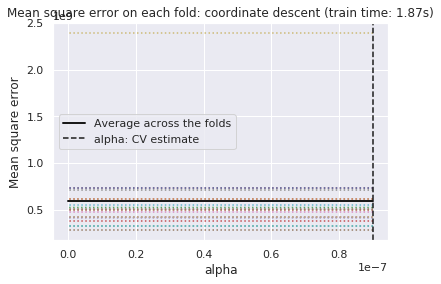

In [180]:
from sklearn.linear_model import LassoCV
# LassoCV: coordinate descent
alphas=[k for k in np.arange(0,1e-07,1e-08)]

# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
model = LassoCV(alphas=alphas, cv=20).fit(X25norm, y25)
t_lasso_cv = time.time() - t1

# Display results
print("Our best alpha is : ", model.alpha_)

plt.figure()
plt.plot(model.alphas_, model.mse_path_, ':')
plt.plot(model.alphas_, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(model.alpha_, linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('alpha')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')

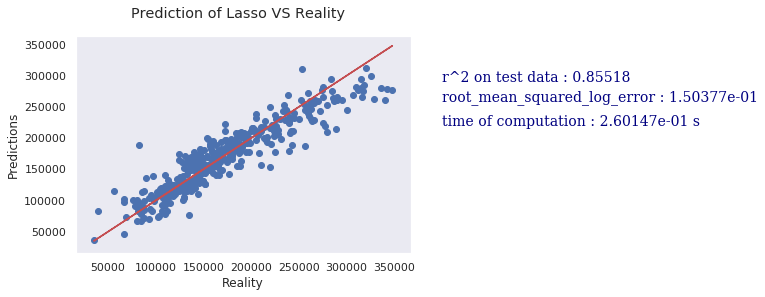

r^2 on test data : 0.85518
root_mean_squared_log_error : 1.50377e-01
time of computation : 2.60147e-01 s


In [181]:
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from math import log10, sqrt
import time 

plt.ylabel('Predictions')
font = {'family': 'serif', 'color':  'navy', 'weight': 'normal', 'size': 14}

X_train, X_test, y_train, y_test = train_test_split(X25norm, y25, test_size=0.33, random_state=42)

alpha = 9e-08
t1 = time.time()

lasso = Lasso(alpha=alpha,  max_iter=3000)

y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
a=(time.time()-t1)

r2_score_lasso = r2_score(y_test, y_pred_lasso)
rmsle_lasso = sqrt(mean_squared_log_error(y_test, y_pred_lasso))

plt.text(400000, 290000,"r^2 on test data : %.5f" % r2_score_lasso, fontdict=font)
plt.text(400000, 260000,"root_mean_squared_log_error : %.5e" % rmsle_lasso, fontdict=font)
plt.text(400000, 220000,'time of computation : %.5e s' % (a), fontdict=font)

plt.plot(y_test, y_test, color='r')
plt.scatter(y_test, y_pred_lasso)
plt.grid()

plt.xlabel('Reality')
plt.ylabel('Predictions')

plt.suptitle('Prediction of Lasso VS Reality')

plt.show()

print("r^2 on test data : %.5f" % r2_score_lasso)
print("root_mean_squared_log_error : %.5e" % rmsle_lasso)
print('time of computation : %.5e s' % (a))

The result is quite less than with all the 80 columns, but there are some probable explanations. We have selected the variables that are the most correlated to our goal of prediction `SalePrice`, so the ones that provide most of informations. However, it doesn't mean that these variables aren't correlated among themselves, and so are redondant. In that case, restrict ourselves only to 25 variables is a loss of information, and consequently a problem for the quality of prediction.

Besides, we have already obtain good results with our big dataframe. Accordingly, we have decided not to loose time on a better selection/restriction of variables and continue with all the 80 columns for the rest of the notbook.

**ELASTICNET REGRESSION**
---

As explained on the scikit-learn documentation (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet), **ElasticNet** is a linear regression model trained with L1 and L2 prior as regularizer. It represents a trade-off between Lasso and Ridge Regression. The objective function we want to minimize is the following :

$$
\underset { w }{ min }  \frac { 1 }{ 2{ n }_{ samples } } { \left\| Xw-y \right\|  }_{ 2 }^{ 2 }+\alpha { \rho \left\| w \right\|  }_{ 1 }+\frac { \alpha (1-\rho ) }{ 2 } { \left\| w \right\|  }_{ 2 }^{ 2 }
$$
Let's use it with parameters $\alpha$ =0.00001 and $\rho$ (ie. l1_ratio)=0.7 (as in the example mentioned previously).

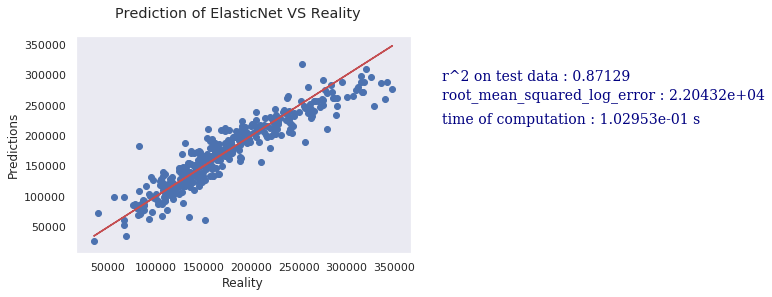

r^2 on test data : 0.87129
root_mean_squared_log_error : 2.20432e+04
time of computation : 1.02953e-01 s


In [151]:
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from math import log10, sqrt
import time 

plt.ylabel('Predictions')
font = {'family': 'serif', 'color':  'navy', 'weight': 'normal', 'size': 14}

X_train, X_test, y_train, y_test = train_test_split(X80norm, y80, test_size=0.33, random_state=42)

alpha = 0.00001
l1_ratio = 0.7
t1 = time.time()

enet = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=3000)

y_pred_enet = enet.fit(X_train, y_train).predict(X_test)

a=(time.time()-t1)

r2_score_enet = r2_score(y_test, y_pred_enet)
rmsle_enet = sqrt(mean_squared_error(y_test, y_pred_enet))

plt.text(400000, 290000,"r^2 on test data : %.5f" % r2_score_enet, fontdict=font)
plt.text(400000, 260000,"root_mean_squared_log_error : %.5e" % rmsle_enet, fontdict=font)
plt.text(400000, 220000,'time of computation : %.5e s' % (a), fontdict=font)

plt.plot(y_test, y_test, color='r')
plt.scatter(y_test, y_pred_enet)
plt.grid()

plt.xlabel('Reality')
plt.ylabel('Predictions')

plt.suptitle('Prediction of ElasticNet VS Reality')
plt.show()

print("r^2 on test data : %.5f" % r2_score_enet)
print("root_mean_squared_log_error : %.5e" % rmsle_enet)
print('time of computation : %.5e s' % (a))

As Lasso, ElasticNet seems to be able to predict efficiently our `SalePrice` value, so let's use Cross Validation to find out which hyperparmeters are the best for him.

Computing regularization path using the coordinate descent lasso...
Our best alpha is :  0.0
Our best rho is :  0.5


(-4.500000000000001e-09, 9.45e-08, 88743928.23047325, 2854126197.5973096)

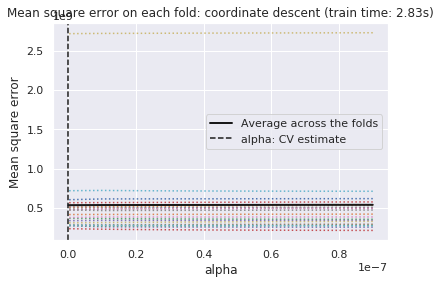

In [58]:
from sklearn.linear_model import ElasticNetCV
import time

alphas=[k for k in np.arange(0,1e-07,1e-08)]

# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
model = ElasticNetCV(alphas=alphas , cv=20).fit(X80norm, y80)
t_lasso_cv = time.time() - t1

# Display results

print("Our best alpha is : ", model.alpha_)
print("Our best rho is : ", model.l1_ratio_ )

plt.figure()
plt.plot(model.alphas_, model.mse_path_, ':')
plt.plot(model.alphas_, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(model.alpha_, linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('alpha')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')

Let's visualize the result with such optimized $\alpha$ and $\rho$!

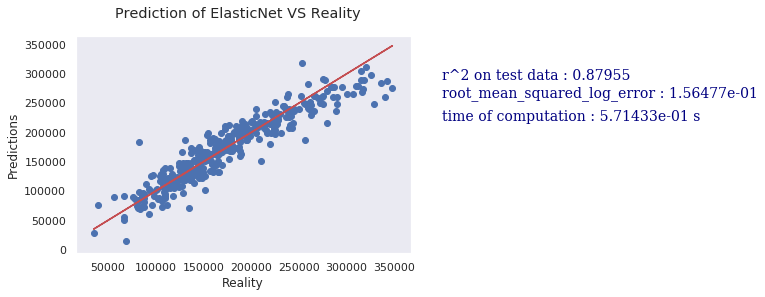

r^2 on test data : 0.87955
root_mean_squared_log_error : 1.56477e-01
time of computation : 5.71433e-01 s


In [60]:
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from math import log10, sqrt
import time 

plt.ylabel('Predictions')
font = {'family': 'serif', 'color':  'navy', 'weight': 'normal', 'size': 14}

X_train, X_test, y_train, y_test = train_test_split(X80norm, y80, test_size=0.33, random_state=42)

alpha = 0
l1_ratio = 0.5
t1 = time.time()

enet = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=3000)

y_pred_enet = enet.fit(X_train, y_train).predict(X_test)
a = time.time() - t1
r2_score_enet = r2_score(y_test, y_pred_enet)
rmsle_enet = sqrt(mean_squared_log_error(y_test, y_pred_enet))

plt.text(400000, 290000,"r^2 on test data : %.5f" % r2_score_enet, fontdict=font)
plt.text(400000, 260000,"root_mean_squared_log_error : %.5e" % rmsle_enet, fontdict=font)
plt.text(400000, 220000,'time of computation : %.5e s' % (a), fontdict=font)

plt.plot(y_test, y_test, color='r')
plt.scatter(y_test, y_pred_enet)
plt.grid()
1.3740485475091941
plt.xlabel('Reality')
plt.ylabel('Predictions')

plt.suptitle('Prediction of ElasticNet VS Reality')
plt.show()

print("r^2 on test data : %.5f" % r2_score_enet)
print("root_mean_squared_log_error : %.5e" % rmsle_enet)
print('time of computation : %.5e s' % (a))

Now that we have several model to compare, it's usefull to draw table with our criteria of decision:

| \ | Lasso | ElasticNet|
|--- | :---: | :---:|
|**r2** | 0.87955 | 0.87955 |
|**rmsle** | 1.56477e-01 | 1.56477e-01 |
| **time of computation** | 5.80772e-01 | 5.71433e-01 s |

**RIDGE REGRESSION**
---

*As explained in https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression, 
the Ridge regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of coefficients. The ridge coefficients minimize a penalized residual sum of squares,the same as the Lasso function.
Compared to Lasso, Ridge Regression better addresses multicollinearity problem between independant features.*

*3- Parameter Optimisation : Find the best value of the alpha parameter*

In that section, we work with a random split for test set and training set

maximum r2_score :  0.879549594573397 alpha_opt :  0.0


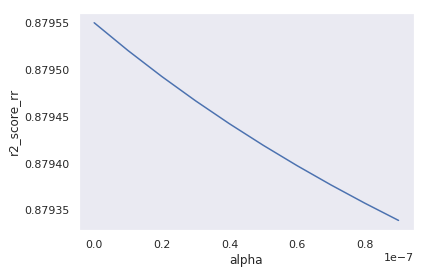

minimum mean_squared_error :  0.024484967690133908 alpha_opt :  0.0


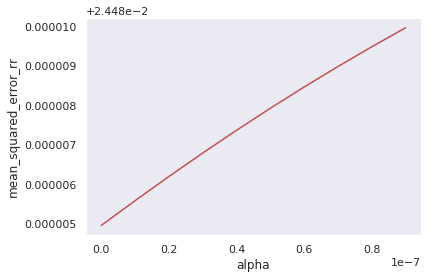

In [32]:
from sklearn.linear_model import Ridge
from sklearn import linear_model
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_log_error



X_train, X_test, y_train, y_test = train_test_split(X80norm, y80, test_size=0.33, random_state=42)


alphas = [ k for k in np.arange(0,1e-7,1e-8) ]

r2_score_rr = []
mean_squared_log_error_rr = [] 

for alpha in alphas :
    clf = Ridge(alpha)
    clf.fit(X_train, y_train)
    y_pred_rr = clf.predict(X_test)
    r2_score_rr.append(r2_score(y_test, y_pred_rr))
    mean_squared_log_error_rr.append(mean_squared_log_error(y_test, y_pred_rr))

print('maximum r2_score : ', max(r2_score_rr), 'alpha_opt : ', 1e-08*r2_score_rr.index(max(r2_score_rr)))    
plt.plot(alphas, r2_score_rr)
plt.ylabel('r2_score_rr')
plt.xlabel('alpha')
plt.grid()
plt.show()

print('minimum mean_squared_error : ', min(mean_squared_log_error_rr), 'alpha_opt : ', 1e-08*mean_squared_log_error_rr.index(min(mean_squared_log_error_rr)))
plt.plot(alphas, mean_squared_log_error_rr, 'r')
plt.ylabel('mean_squared_error_rr')
plt.xlabel('alpha')
plt.grid()
plt.show()



Those graphs convey into the choice of the optimal value of alpha.

*For the value optimal value alpha = 0 :*

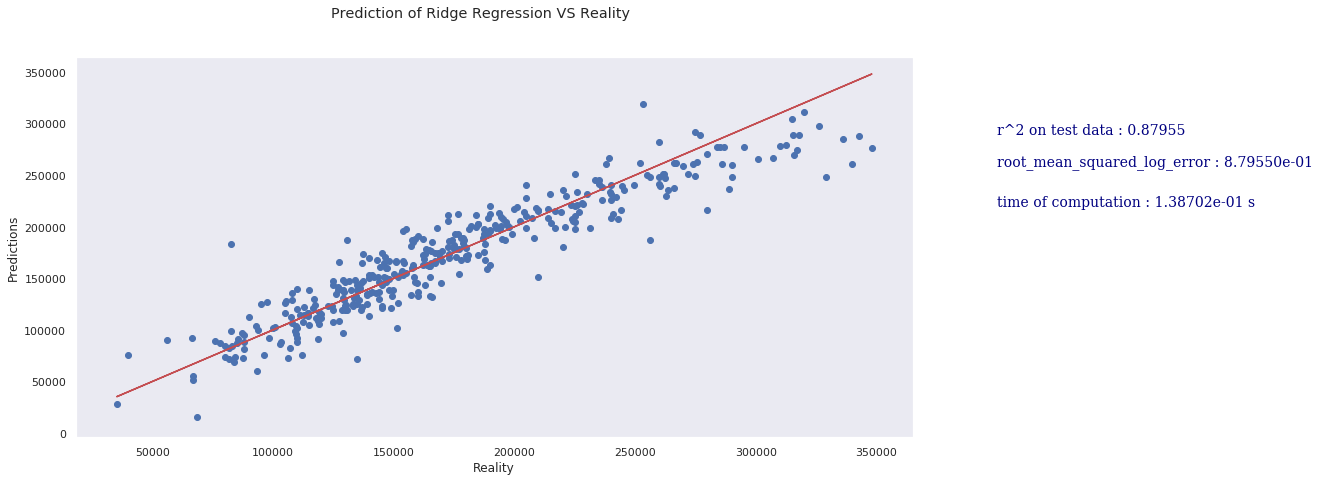

r^2 on test data : 0.87955
root_mean_squared_log_error : 8.79550e-01
time of computation : 1.38702e-01 s


In [36]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn import linear_model
from math import log10, sqrt
import time 

figure = plt.figure(figsize=(15,7))
plt.ylabel('Predictions')
font = {'family': 'serif', 'color':  'navy', 'weight': 'normal', 'size': 14}
    
# Split data in train set and test set
X_train, X_test, y_train, y_test = train_test_split(X80norm, y80, test_size=0.33, random_state=42)

t1 = time.time()

# We build, train the model and make our predictions
clf = Ridge(alpha=0)
clf.fit(X_train, y_train) 
y_pred_rr = clf.predict(X_test)
a = time.time()-t1

# Computing of performance estimators
r2_score_rr = r2_score(y_test, y_pred_rr)
mean_squared_log_error_rr = (mean_squared_log_error(y_test, y_pred_rr))
rmsle_rr = sqrt(mean_squared_log_error(y_test, y_pred_rr))

plt.text(400000, 290000,"r^2 on test data : %.5f" % r2_score_rr, fontdict=font)
plt.text(400000, 260000,"root_mean_squared_log_error : %.5e" % r2_score_rr, fontdict=font)
plt.text(400000, 220000,'time of computation : %.5e s' % (a), fontdict=font)

plt.plot(y_test, y_test, color='r')
plt.scatter(y_test, y_pred_rr, color='b')

plt.xlabel('Reality')
plt.ylabel('Predictions')

plt.suptitle('Prediction of Ridge Regression VS Reality')
plt.grid()
plt.show()

print("r^2 on test data : %.5f" % r2_score_rr)
print("root_mean_squared_log_error : %.5e" % r2_score_rr)
print('time of computation : %.5e s' % (a))

*Ridge Regression using Cross-Validation*

In order to improve the efficiency of our model and ensure a better generalization to unknown data, we use a cross-validation process that allows to train the algorithm on the whole data repetedly.  

Our first approach, was to perform te cross-validation using the optimal value of alpha on each sample. Here are our results : 

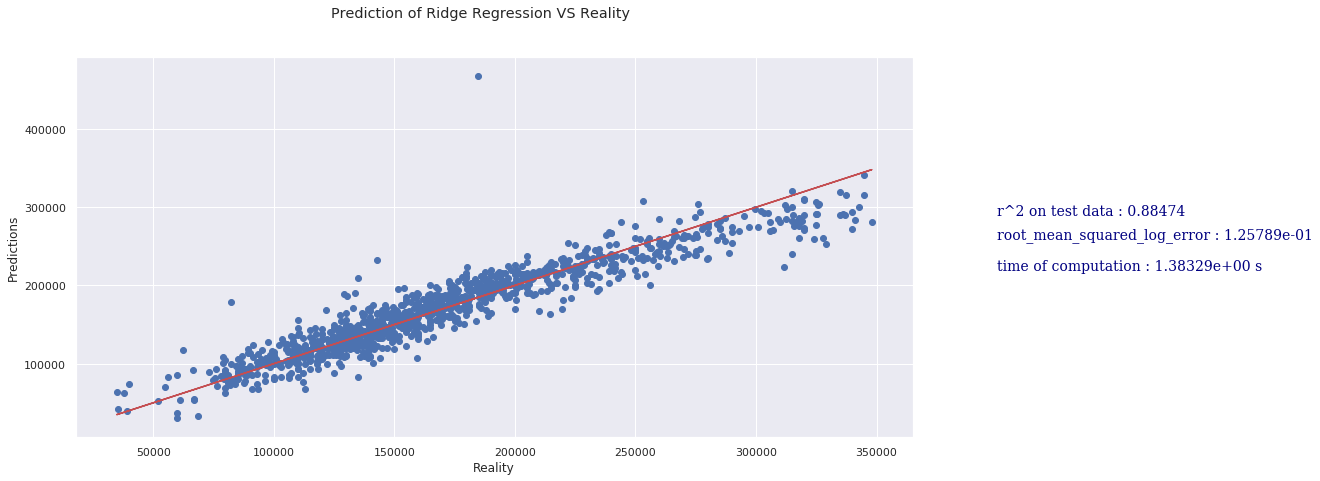

r^2 on test data : 0.88474
root_mean_squared_log_error : 1.25789e-01
time of computation : 1.38329e+00 s


In [30]:
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn import linear_model
from math import log10, sqrt
import time 


figure = plt.figure(figsize=(15,7))
plt.ylabel('Predictions')
font = {'family': 'serif', 'color':  'navy', 'weight': 'normal', 'size': 14}

alphas_max=np.zeros(5) 

## With all the features

t1 = time.time()

# We build, train the model and make our predictions
clf = linear_model.RidgeCV(alphas=alphas_max, cv=5)
clf.fit(X80norm, y80) 
y_pred_rr = clf.predict(X80norm)
a = time.time()-t1

# Computing of performance estimators
r2_score_rr = r2_score(y80, y_pred_rr)
rmsle_rr = sqrt(mean_squared_log_error(y80, y_pred_rr))


plt.text(400000, 290000,"r^2 on test data : %.5f" % r2_score_rr, fontdict=font)
plt.text(400000, 260000,"root_mean_squared_log_error : %.5e" % rmsle_rr, fontdict=font)
plt.text(400000, 220000,'time of computation : %.5e s' % (a), fontdict=font)
    
plt.plot(y80, y80, color='r')
plt.scatter(y80, y_pred_rr, color='b')

plt.grid()
plt.xlabel('Reality')
plt.ylabel('Predictions')

plt.suptitle('Prediction of Ridge Regression VS Reality')
plt.grid()
plt.show()

print("r^2 on test data : %.5f" % r2_score_rr)
print("root_mean_squared_log_error : %.5e" % rmsle_rr)
print('time of computation : %.5e s' % (a))

*The use of the optimal value of alpha while performing cross-validation gives even better results than a random split of dataset. But we can see that all the features are needed to make good predictions*

**Conclusion for the Ridge Regression**

This model provides really good results having an alpha parameter at 2e-07, especially using 5 cross-validation. 

| \ | Lasso | ElasticNet| Ridge
|--- | :---: | :---:| :---:|
|**r2** | 0.87955 | 0.87955 | 0.88474 |
|**rmsle** | 1.56477e-01 | 1.56477e-01 | 1.25789e-01 |
| **time of computation** | 5.80772e-01 | 5.71433e-01 s | 1.38329e+00 s|


**DECISION TREES**
---

Now we want to check if methods that don't belongs to the scikit-learn flowchart can also prdeict efficiently our `SalePrice`. The first method which rolls us away from regression stuff is **Decision Tree**.
Let's see if it's accurate.

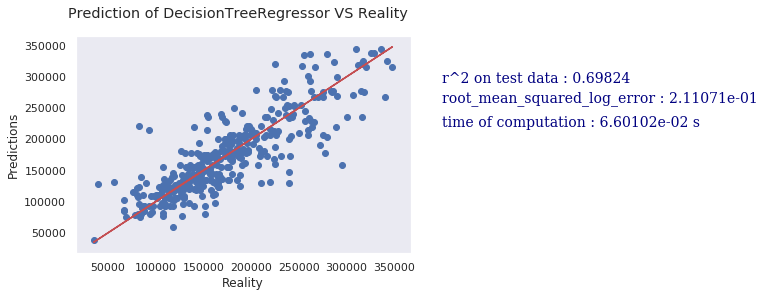

r^2 on test data : 0.69824
root_mean_squared_log_error : 2.11071e-01
time of computation : 6.60102e-02 s


In [68]:
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn import tree
from math import log10, sqrt
import time 

plt.ylabel('Predictions')
font = {'family': 'serif', 'color':  'navy', 'weight': 'normal', 'size': 14}

X_train, X_test, y_train, y_test = train_test_split(X80norm, y80, test_size=0.33, random_state=42)

t1 = time.time()

tree_clf = tree.DecisionTreeRegressor()

y_pred_tree = tree_clf.fit(X_train, y_train).predict(X_test)

r2_score_tree = r2_score(y_test, y_pred_tree)
rmsle_tree = sqrt(mean_squared_log_error(y_test, y_pred_tree))

a=time.time()-t1

plt.text(400000, 290000,"r^2 on test data : %.5f" % r2_score_tree, fontdict=font)
plt.text(400000, 260000,"root_mean_squared_log_error : %.5e" % rmsle_tree, fontdict=font)
plt.text(400000, 220000,'time of computation : %.5e s' % (a), fontdict=font)

plt.plot(y_test, y_test, color='r')
plt.scatter(y_test, y_pred_tree)
plt.grid()

plt.xlabel('Reality')
plt.ylabel('Predictions')

plt.suptitle('Prediction of DecisionTreeRegressor VS Reality')
plt.show()

print("r^2 on test data : %.5f" % r2_score_tree)
print("root_mean_squared_log_error : %.5e" % rmsle_tree)
print('time of computation : %.5e s' % (a))

Here we don't tune anything, "decisons" are token by the algorithm. As a consequence, the values of our criteria of evaluation vary each time we run previous cell. Here are some results we obtain from this cell:

| \ | run 1 | run 2 | run 3 | run 4 | run 5 | mean |
|--- | :---: | :---: | :---: |  :---: | :---: | :---: |
|**r2** | 0.71323 |  0.68217 | 0.69254   |  0.71357  | 0.69824  | **0.699950** | 
|**rmsle** | 2.04715e-01  |  2.12653e-01 |  2.10341e-01 |  2.04825e-01 |  2.11071e-01  | **2.08721e-01** |
| **time of computation (in s)** | 3.27566e-02  | 3.14529e-02  |  5.12009e-02 | 3.07293e-02  | 6.60102e-02   | **4.242998e-02** |

It's also usefull to look at other techniques derive from tree and available with sklearn : the *RandomForest* algorithm & the *Extra-Trees* method. this two ensemble method are perturb-and-combine techniques specifically designed for trees. This means a diverse set of classifiers is created by introducing randomness in the classifier construction. The prediction of the ensemble is given as the averaged prediction of the individual classifiers.

We'll begin with **RandomForestRegressor**.

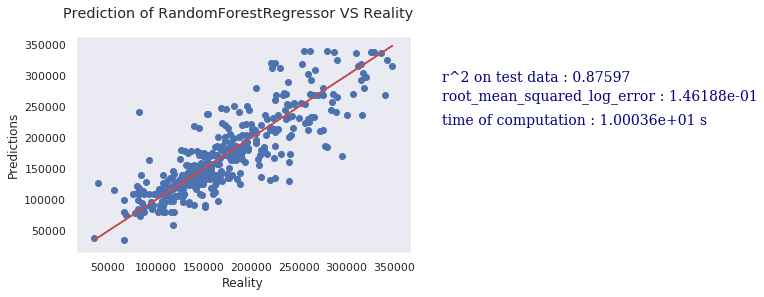

r^2 on test data : 0.87597
root_mean_squared_log_error : 1.46188e-01
time of computation : 1.00036e+01 s


In [97]:
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from math import log10, sqrt
import time 

plt.ylabel('Predictions')
font = {'family': 'serif', 'color':  'navy', 'weight': 'normal', 'size': 14}

X_train, X_test, y_train, y_test = train_test_split(X80norm, y80, test_size=0.33, random_state=42)

t1 = time.time()

forest = ensemble.RandomForestRegressor(n_estimators = 1000)

y_pred_forest = forest.fit(X_train, y_train).predict(X_test)
a = time.time()-t1
r2_score_forest = r2_score(y_test, y_pred_forest)
rmsle_forest = sqrt(mean_squared_log_error(y_test, y_pred_forest))

plt.text(400000, 290000,"r^2 on test data : %.5f" % r2_score_forest, fontdict=font)
plt.text(400000, 260000,"root_mean_squared_log_error : %.5e" % rmsle_forest, fontdict=font)
plt.text(400000, 220000,'time of computation : %.5e s' % (a), fontdict=font)

plt.plot(y_test, y_test, color='r')
plt.scatter(y_test, y_pred_tree)
plt.grid()

plt.xlabel('Reality')
plt.ylabel('Predictions')

plt.suptitle('Prediction of RandomForestRegressor VS Reality')
plt.show()

print("r^2 on test data : %.5f" % r2_score_forest)
print("root_mean_squared_log_error : %.5e" % rmsle_forest)
print('time of computation : %.5e s' % (a))

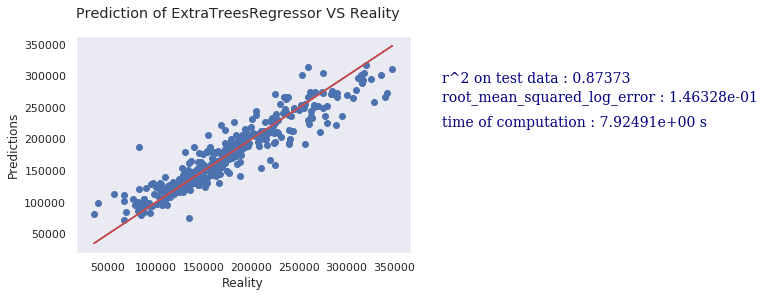

r^2 on test data : 0.87373
root_mean_squared_log_error : 1.46328e-01
time of computation : 7.92491e+00 s


In [95]:
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from math import sqrt
import time 

plt.ylabel('Predictions')
font = {'family': 'serif', 'color':  'navy', 'weight': 'normal', 'size': 14}

X_train, X_test, y_train, y_test = train_test_split(X80norm, y80, test_size=0.33, random_state=42)

t1 = time.time()

extra = ensemble.ExtraTreesRegressor(n_estimators = 1000)

y_pred_extra = extra.fit(X_train, y_train).predict(X_test)
a = time.time()-t1

r2_score_extra = r2_score(y_test, y_pred_extra)
rmsle_extra = sqrt(mean_squared_log_error(y_test, y_pred_extra))

plt.text(400000, 290000,"r^2 on test data : %.5f" % r2_score_extra, fontdict=font)
plt.text(400000, 260000,"root_mean_squared_log_error : %.5e" % rmsle_extra, fontdict=font)
plt.text(400000, 220000,'time of computation : %.5e s' % (a), fontdict=font)

plt.plot(y_test, y_test, color='r')
plt.scatter(y_test, y_pred_extra)
plt.grid()

plt.xlabel('Reality')
plt.ylabel('Predictions')

plt.suptitle('Prediction of ExtraTreesRegressor VS Reality')
plt.show()

print("r^2 on test data : %.5f" % r2_score_extra)
print("root_mean_squared_log_error : %.5e" % rmsle_extra)
print('time of computation : %.5e s' % (a))

let's complete our table with what we found:

| \ | Lasso | ElasticNet| Ridge| DecisionTreeRegressor | RandomForestRegressor | ExtraTreesRegressor |
|--- | :---: | :---:|:---:|:---:|:---:|:---:|
|**r2** | 0.87955 | 0.87955 | 0.88474 | 0.699950 | 0.87597 | 0.87373 |
|**rmsle** | 1.56477e-01 | 1.56477e-01 | 8.84737e-01 | 2.08721e-01 | 1.46188e-01 |  1.46328e-01 |
| **time of computation** | 5.80772e-01 | 1.02953e-01 s | 1.07718e+00 s|4.242998e-02 |1.00036e+01 | 7.92491e+00 s |

As this table shows, Decision Tree aren't as powerful on our problem as Regression algorithm are. Let's try another method, namely neural networks.

**NEURAL NETWORKS**
---

We used **MLPRegressor** estimator from scikit-learn library. MLP stands for Multi Layer Perceptron, which means we will build a neural network with one or more hidden layers, so it enables us to play with Deep Learning notion.

However, when we tried to implement **MLPRegressor**  on our normalized data, it didn't go so well...

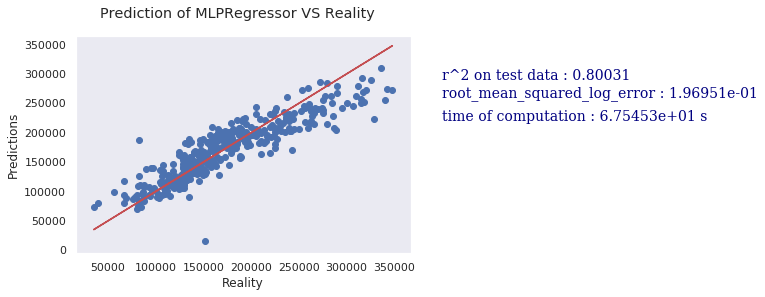

In [100]:
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from math import sqrt
import time 

plt.ylabel('Predictions')
font = {'family': 'serif', 'color':  'navy', 'weight': 'normal', 'size': 14}

X_train, X_test, y_train, y_test = train_test_split(X80norm, y80, test_size=0.33, random_state=42)

t1 = time.time()

mlp = MLPRegressor(hidden_layer_sizes=(100,80,80), max_iter=1000)

mlp.fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)
r2_score_mlp = r2_score(y_test, y_pred_mlp)
rmsle_mlp = sqrt(mean_squared_log_error(y_test, y_pred_mlp))

plt.text(400000, 290000,"r^2 on test data : %.5f" % r2_score_mlp, fontdict=font)
plt.text(400000, 260000,"root_mean_squared_log_error : %.5e" % rmsle_mlp, fontdict=font)
plt.text(400000, 220000,'time of computation : %.5e s' % (time.time()-t1), fontdict=font)

plt.plot(y_test, y_test, color='r')
plt.scatter(y_test, y_pred_mlp)
plt.grid()

plt.xlabel('Reality')
plt.ylabel('Predictions')

plt.suptitle('Prediction of MLPRegressor VS Reality')
plt.show()

Doesn't look so good right?

This is a major drawback of Neural Networks : they are like a "black box", meaning that we don’t know how and why it comes up with a certain output. Contrary to Decision Tree for instance, they aren't easy to interpret. It's quite okay when we succeed to build an efficient NN on a given problem, but because the effect of adding or removing neurons or layers isn't clear, this successfull building is hard to achieve. 

There might be a miraculous combination of layers, neurons and activation functions that outshines Regression algorithms. However, as we've already reach good results with them, we decided also to not spend so much time on NN. 

---
CONCLUSION
---

Let's see how goes our table of evaluation :

| \ | Lasso | ElasticNet| Ridge| DecisionTreeRegressor | RandomForestRegressor | ExtraTreesRegressor | MLPRegressor |
|--- | :---: | :---:|:---:|:---:|:---:|:---:| :---:| 
|**r2** | 0.87955 | 0.87955 | **0.88474** | 0.699950 | 0.87597 | 0.87373 |0.80031 |
|**rmsle** | 1.56477e-01 | 1.56477e-01 | **8.84737e-01** | 2.08721e-01 | 1.46188e-01 |  1.46328e-01 | 1.96951e-01 |
| **time of computation** | 5.80772e-01 | 1.02953e-01 s | 1.07718e+00 s|4.242998e-02 |1.00036e+01 | 7.92491e+00 s | 6.75453e+0.1|

**Ridge Regression** gives the best r2 and rmsle. Despite its time of computation is far not the best, our dataset is small enough to tolerate it.

So let's use Ridge Regression with our optimized hyperparamater $\alpha=0$ on the given test data!

In [34]:
#we prepare the given test data to apply our model on it
testDF = pd.read_csv(base + 'challenge_data/test.csv', 
                           sep=',', 
                           header='infer')

column_names = list(testDF.columns.values)

corrDF = testDF.corr()
column_names_in_corr = list(corrDF.columns.values)

column_names_notin_corr = []
for x in column_names:
    if not (x in column_names_in_corr) :
        column_names_notin_corr.append(x)

for x in column_names_notin_corr:
    testDF[x] = testDF[x].astype('category')
    testDF[x+'_cat'] = testDF[x].cat.codes
    
inter_testDF = testDF.drop(column_names_notin_corr, axis=1)

inter_testDF['LotFrontage'] = inter_testDF['LotFrontage'].astype('category').cat.add_categories([-1]).fillna(-1)
inter_testDF['MasVnrArea'] = inter_testDF['MasVnrArea'].astype('category').cat.add_categories([-1]).fillna(-1)
inter_testDF['GarageYrBlt'] = inter_testDF['GarageYrBlt'].astype('category').cat.add_categories([-1]).fillna(-1)

inversenorms80 = [1/n for n in norms80]
X80testnorm = np.multiply(np.array(inter_testDF), inversenorms80)

In [35]:
#we make our prediction
from sklearn.linear_model import Ridge

clf = Ridge(alpha=0)
clf.fit(X80norm, y80) 
y80testpred = clf.predict(X80testnorm)

In [72]:
#we translate them onto .csv format
submissionDF = pd.DataFrame()

submissionDF['Id'] = testDF['Id']
submissionDF['SalePrice'] = pd.Series(y80testpred, index=submissionDF.index)

submissionDF.to_csv(path_or_buf=base + 'challenge_data/our_submission.csv', index=False)






**THE END**
---